# Polish Traffic Sign Recognition

Lib import

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# import skimage.data
import skimage.transform
from skimage import io

import tensorflow as tf

import random
import os

%matplotlib inline

Check our directories

In [2]:
print(os.listdir("./data"))

['labels.csv', 'test', 'train']


In [3]:
print(os.listdir("./data/train"))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91']


In [4]:
print(os.listdir("./data/test"))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91']


Parse and load trening data

In [5]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".jpg")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            #print(f)
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels

In [6]:
train_data_dir = "./data/train"
test_data_dir = "./data/test"

images, labels = load_data(train_data_dir)

Check data


In [7]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 92
Total Images: 16746




Display the first image of each label.


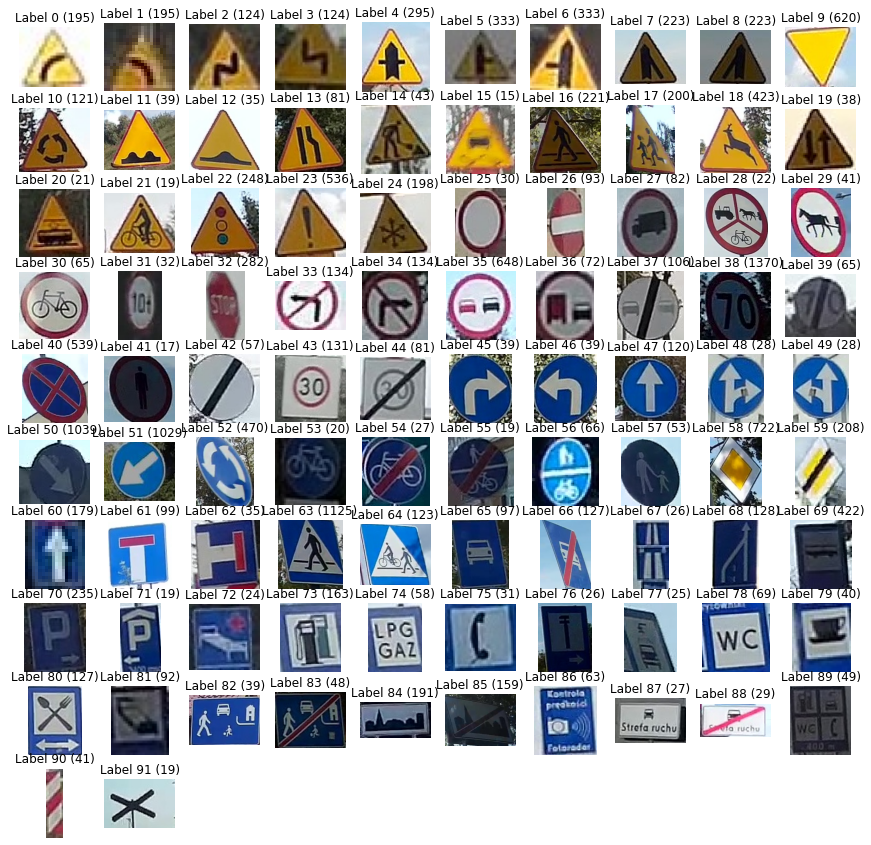

In [8]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(10, 10, i) # X - Y
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

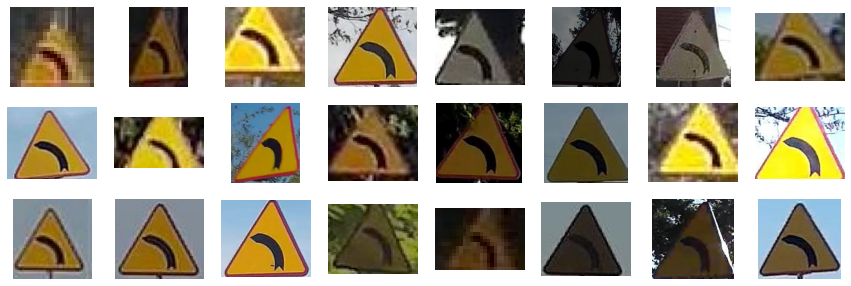

In [10]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # max 24
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 x 8
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 1)

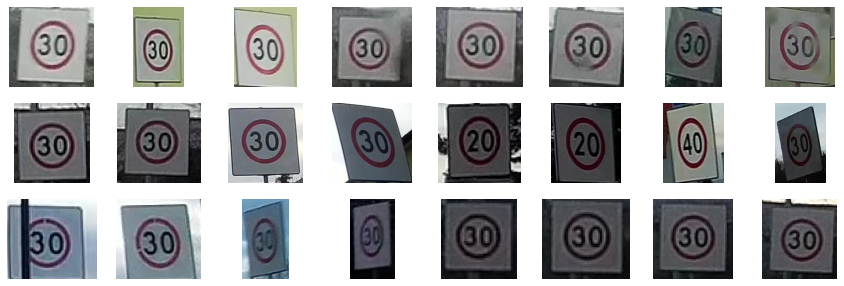

In [11]:
display_label_images(images, 43)

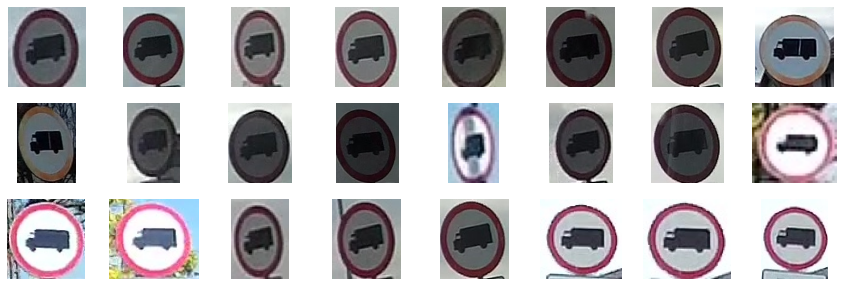

In [12]:
display_label_images(images, 27)

What is image size?

In [13]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (21, 25, 3), min: 0, max: 255
shape: (44, 48, 3), min: 0, max: 237
shape: (67, 75, 3), min: 0, max: 170
shape: (53, 61, 3), min: 0, max: 164
shape: (213, 194, 3), min: 0, max: 166


Change all images size to 32x32

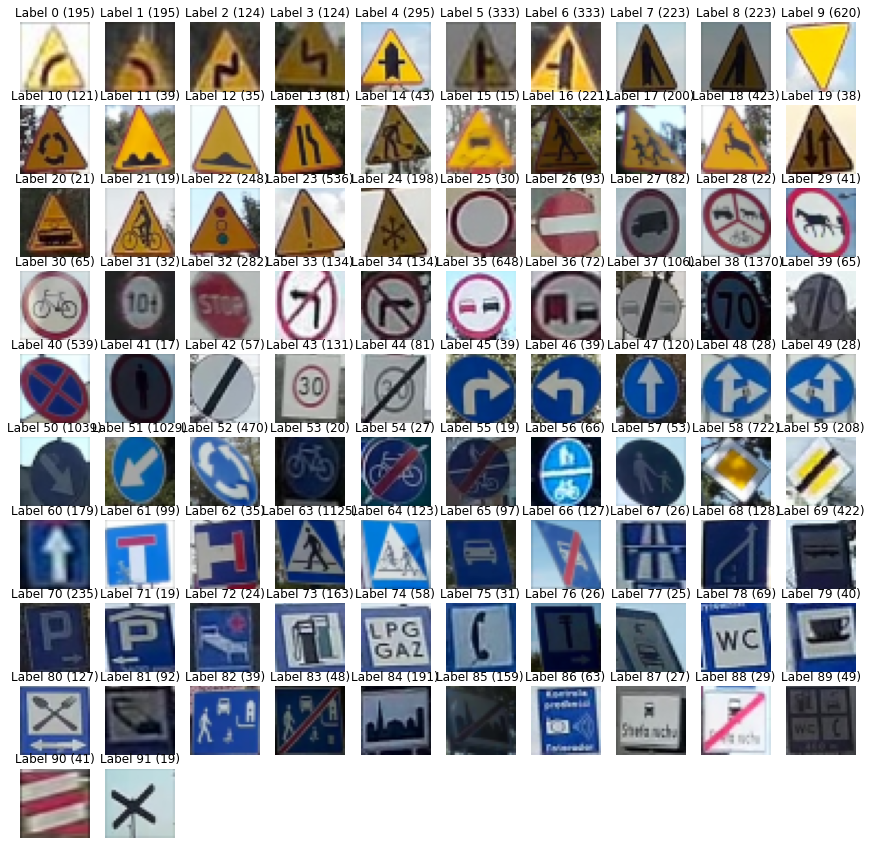

In [14]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

Check sizes and min and max also. It's betweeen 0 and 1.

In [15]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0014562270220588236, max: 1.0
shape: (32, 32, 3), min: 0.006222986792754482, max: 0.8895056195284579
shape: (32, 32, 3), min: 0.0008840199415049955, max: 0.6054150829021877
shape: (32, 32, 3), min: 0.0025295513781674406, max: 0.4710136721054689
shape: (32, 32, 3), min: 0.00500211772342066, max: 0.5632259672684413


# Model building

In [16]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (16746,) 
images:  (16746, 32, 32, 3)


In [17]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.compat.v1.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.compat.v1.layers.flatten(images_ph)

    # Fully connected layer.
    # Generates logits of size [None, 92]
    logits = tf.compat.v1.layers.dense(images_flat, 92, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(input=logits, axis=1)

    # Define the loss function.
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.compat.v1.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("flatten/Reshape:0", shape=(None, 3072), dtype=float32)
logits:  Tensor("dense/Relu:0", shape=(None, 91), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(None,), dtype=int64)


C:\Users\Floxbiee\AppData\Local\Temp\ipykernel_16936\2120337729.py:12: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  images_flat = tf.compat.v1.layers.flatten(images_ph)
C:\Users\Floxbiee\AppData\Local\Temp\ipykernel_16936\2120337729.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(images_flat, 91, tf.nn.relu)


# Training

In [18]:
# Create a session to run the graph we created.
session = tf.compat.v1.Session(graph=graph)

# First step is always to initialize all variables.
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [19]:
for i in range(201):
    _, loss_value = session.run([train, loss],
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

InvalidArgumentError: Graph execution error:

Detected at node 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Floxbiee\AppData\Local\Temp\ipykernel_16936\2120337729.py", line 24, in <cell line: 5>
      loss = tf.reduce_mean(input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))
Node: 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 91 which is outside the valid range of [0, 91).  Label values: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 54 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 68 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 73 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 76 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 89 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91 91
	 [[{{node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]

Original stack trace for 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits':
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3312.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
    await self.process_one()
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 493, in process_one
    await dispatch(*args)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
    await result
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
    reply_content = await reply_content
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
    result = self._run_cell(
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
    return runner(coro)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Floxbiee\AppData\Local\Temp\ipykernel_16936\2120337729.py", line 24, in <cell line: 5>
    loss = tf.reduce_mean(input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\ops\nn_ops.py", line 4430, in sparse_softmax_cross_entropy_with_logits_v2
    return sparse_softmax_cross_entropy_with_logits(
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\ops\nn_ops.py", line 4343, in sparse_softmax_cross_entropy_with_logits
    cost = _sparse_softmax_cross_entropy_with_rank_2_logits(
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\ops\nn_ops.py", line 4242, in _sparse_softmax_cross_entropy_with_rank_2_logits
    cost, _ = gen_nn_ops.sparse_softmax_cross_entropy_with_logits(
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 11512, in sparse_softmax_cross_entropy_with_logits
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\framework\op_def_library.py", line 797, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "C:\Users\Floxbiee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\framework\ops.py", line 3793, in _create_op_internal
    ret = Operation(


## Using the Model


In [ ]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

['51', '58', '51', '69', '57', '17', '34', '69', '5', '15']
[51 57 51 69 57  5 34 69  5 15]


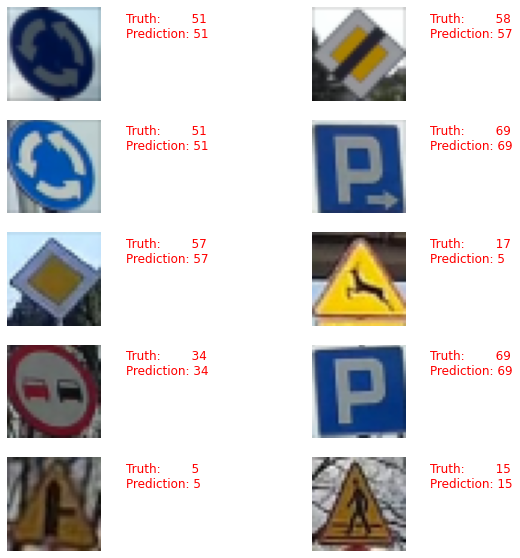

In [ ]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

## Check accuracy of model by testing on test data

In [ ]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

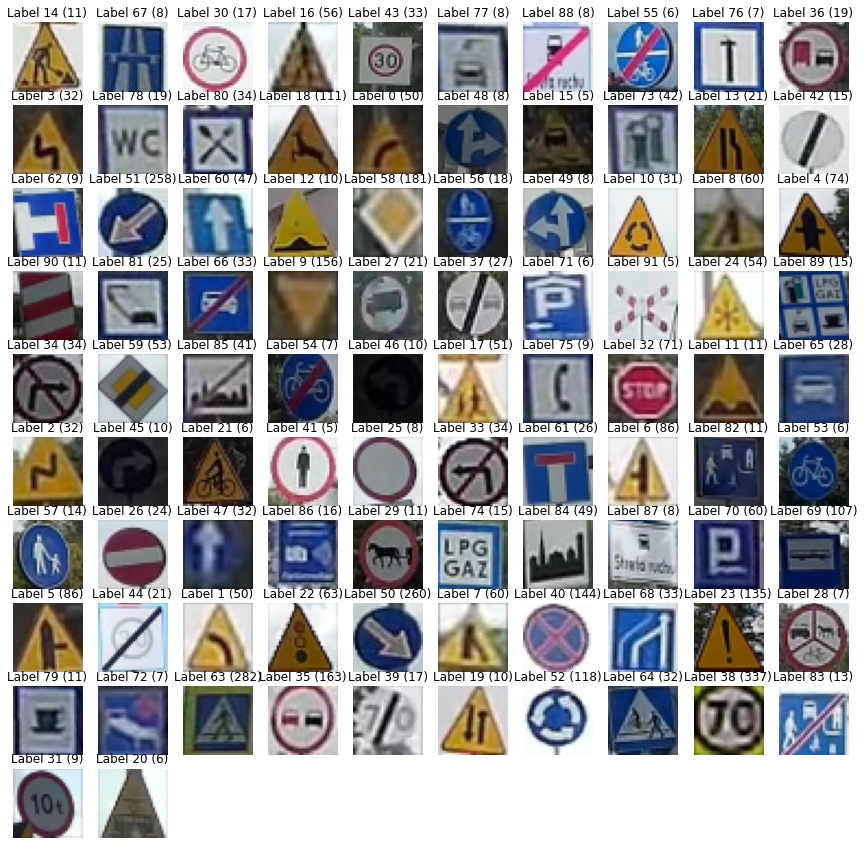

In [ ]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [ ]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.000


In [ ]:
# Close the session. This will destroy the trained model.
session.close()